# Machine Learning for Text Processing and Sentiment Analysis

## Richard Lipkin, PhD (richlipkin@gmail.com)

#### Purpose: To use text processing techniques on the training set from the [IMDB Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) and train a machine learning classifier to perform sentiment analysis on the test set.

Text processing and sentiment analysis are common topics of machine learning applications. Therefore, this notebook extends the techniques employed by previous projects. The following sources were valuable in the preparation of this work:

1. [Risueño T. What Is the Difference between Stemming and Lemmatization? 2018.](https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/)
1. [Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011). 2011.](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)
1. [Natural Language Toolkit Project. Natural Language Toolkit Documentation. 2017.](https://github.com/nltk/nltk/wiki)
1. [Kub A. Sentiment Analysis with Python (Part 1). 2018.](https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184)
1. [Nabi J. Machine Learning - Text Processing. 2018.](https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958)
1. [Scikit-learn Developers. Working with Text Data. 2017.](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)
1. [Scikit-learn Developers. Tuning the Hyper-Parameters of an Estimator. 2017.](http://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)

## 0. Import
Let's get started by importing all the packages we will need.

In [1]:
import pandas as pd
import sys  
import os
import io
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from  sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## 1. Read in review data

Next, we read in the text files according to the directory structure of the dataset. We incorporate the labels as 1 and 0 for positive and negative reviews, respectively. We save the raw input to a CSV and print the head of the dataframe to verify correct input. 

In [2]:
# set default encoding to utf8  
reload(sys)  
sys.setdefaultencoding('utf8')

folder = 'aclImdb'
labels = {'pos': 1, 'neg': 0}
df = pd.DataFrame()
for f in ('test', 'train'):    
    for l in ('pos', 'neg'):
        path = os.path.join(folder, f, l)
        for file in os.listdir (path) :
            with io.open(os.path.join(path, file),'r',encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]],ignore_index=True)
df.columns = ['review', 'sentiment']
df.to_csv('movie_review_data.csv', index=False, encoding='utf-8')

In [3]:
df.head()

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


## 2. Tokenize

We use the tokenize function to split the review text strings into a series of words.

In [4]:
nltk.download('punkt')

reviews = df.review.str.cat(sep=' ')
tokens = word_tokenize(reviews)

## 3. Create a frequency distribution of tokens

We output a list of the 50 most frequently occurring tokens in order. We see that many of the most common tokens at this stage probably have little to do with sentiment. There is lots of punctuation, single- and 2-letter words, and words like "and" and "the." We will clean the results in the next step.

In [5]:
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

[u'the',
 u',',
 u'.',
 u'a',
 u'and',
 u'of',
 u'to',
 u'is',
 u'/',
 u'>',
 u'<',
 u'br',
 u'in',
 u'I',
 u'it',
 u'that',
 u"'s",
 u'this',
 u'was',
 u'The',
 u'as',
 u'with',
 u'movie',
 u'for',
 u'film',
 u')',
 u'(',
 u'but',
 u"''",
 u"n't",
 u'``',
 u'on',
 u'you',
 u'are',
 u'not',
 u'have',
 u'his',
 u'be',
 u'!',
 u'he',
 u'one',
 u'at',
 u'by',
 u'an',
 u'all',
 u'who',
 u'they',
 u'from',
 u'like',
 u'It']

## 4. Clean the list of tokens

Next, we filter the list of tokens to remove any terms that are probably not related to sentiment. We do this by removing tokens found in the NLTK "stopwords" corpus from the list of tokens. We also filter out several other short passages and punctuation. By doing this, we arrive at a list of 50 most common tokens that looks significantly better.

In [6]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if ((not (str(w)) in stop_words) and not (str(w) in ['br','I','\'s','The','n\'t','It','This','...','And','A','In','If','--']) and not ((str(w)) in ',./><()``!?:-;\'\''))]

frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

[u'movie',
 u'film',
 u'one',
 u'like',
 u'good',
 u'would',
 u'time',
 u'really',
 u'see',
 u'even',
 u'story',
 u'much',
 u'could',
 u'get',
 u'people',
 u'bad',
 u'great',
 u'well',
 u'first',
 u'made',
 u'also',
 u'make',
 u'way',
 u'movies',
 u'But',
 u'think',
 u'characters',
 u'character',
 u'films',
 u'seen',
 u'watch',
 u'many',
 u'acting',
 u'plot',
 u'know',
 u'never',
 u'two',
 u'There',
 u'show',
 u'little',
 u'love',
 u'best',
 u'life',
 u'ever',
 u'better',
 u'say',
 u'scene',
 u'He',
 u'end',
 u'scenes']

## 5. WordCloud of cleaned tokens list

We don't use this frequency distribution in the prediction model below, so let's visualize the results. We use the WordCloud library to create a visualization of the 50 most common tokens that are actually likely to be related to sentiment (i.e., after punctuation, very short words, and stopwords are removed).

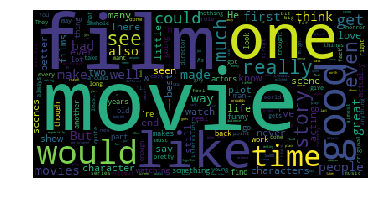

In [7]:
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 6. Define preprocessing functions for training and test datasets
Now we define the preprocessing functions to clean up the complete review strings.

First, we define the replacestopwords function to replace stopwords from the strings containing full reviews. Initially, we split the text into a list of individual words, and then we add the words that are not stopwords to a new word list. Finally, we join that list of words together into a string and return the string.

Then, we set up variables REPLACE_NO_SPACE and REPLACE_WITH_SPACE as calls to a function that removes other unwanted noisy features, such as punctuation.

We also define the preprocess_review function to apply all of this processing to each review via a unified function call.

In [8]:
def replacestopwords(review):
    text_add=[]
    text=review.split(' ') # split the text into a list of individual words
    for i in text:
        if i not in stop_words:
            text_add.append(i) # add the words that are not stopwords to a new list of words
    text_str= ' '.join(text_add) # join the stopword-less list of words together into a new string
    return text_str

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_review(review):
    review = [REPLACE_NO_SPACE.sub("", review.lower())]
    review = [REPLACE_WITH_SPACE.sub(" ", str(review))]
    review = replacestopwords(str(review))
    return review

## 7. Define training and test sets (raw and clean)

Next, we define the training and test sets both with and without preprocessing (raw and clean). There are 25,000 reviews for training and 25,000 for testing. We use the split between training and test sets that is provided by the creators of the dataset according to the directory structure from which the data were initially loaded. 

To generate the clean datasets, we call the preprocessing function and subtract the first 4 and last 4 characters from each entry. We do this because the unicode-to-string conversions employed in the preprocessing algorithm insert unwanted brackets and quotes at the beginning and end of each review.

Then, we output an example of both the raw and preprocessed versions of a single review. We can see that capital letters, punctuation, and stopwords have been correctly removed from the review in the preprocessed version.

In [9]:
X_train = df.loc[:24999, 'review'].values
y_train = df.loc[:24999, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

X_train_clean=[]
X_test_clean=[]

for i in range(len(X_train)):
    add=unicode(str(preprocess_review(str(X_train[i]))), 'utf-8')
    X_train_clean.append(add[4:len(add)-4]) # Remove the first and last 4 characters
for j in range(len(X_test)):
    add=unicode(str(preprocess_review(str(X_test[j]))), 'utf-8')
    X_test_clean.append(add[4:len(add)-4])
    
str(X_train[0]) # Before cleaning

"I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge."

In [10]:
str(X_train_clean[0]) # After cleaning

'i went saw movie last night coaxed friends mine ill admit reluctant see knew ashton kutcher able comedy wrong kutcher played character jake fischer well kevin costner played ben randall professionalism sign good movie toy emotions one exactly entire theater sold overcome laughter first half movie moved tears second half exiting theater saw many women tears many full grown men well trying desperately let anyone see crying movie great suggest go see judge'

## 8. Convert the text corpus into feature vectors

We use the TF-IDF vectorizer and transformer to convert the text corpus into feature vectors. This is a method of extracting features from the body of text. We use the "Bag of Words" approach, which creates a vocabulary of words in the text corpus and represents each word's presence or absence in each review numerically.

Here, we use the Term Frequency-Inverse Document Frequency technique. We take the term frequency, TF (the number of times a term appears in the document) and multiply by the inverse document frequency, IDF = log (N/n), where N is the total number of reviews and n is the number of reviews in which the term appears. IDF is greater for rare terms, so the expression TF * IDF has greater values for terms that are distinctly associated with a given review as opposed to other reviews.

In [11]:
vectorizer = TfidfVectorizer()

train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

train_vectors_clean = vectorizer.fit_transform(X_train_clean)
test_vectors_clean = vectorizer.transform(X_test_clean)

## 9. Train models and use them to predict sentiment of passages in the test set

Next, we use the training set to train the models we will use to predict the sentiment of the test set reviews. We select the multinomial Naive Bayes (NB) classifier and train models using both the raw and preprocessed datasets. Then, we use the trained model to predict the sentiment of passages in the test set for both the raw and preprocessed datasets.

In [12]:
clf = MultinomialNB().fit(train_vectors, y_train)
clf_clean = MultinomialNB().fit(train_vectors_clean, y_train)

predicted = clf.predict(test_vectors)
predicted_clean = clf_clean.predict(test_vectors_clean)

## 10. Output results using NB classifier

Then we output the classification report and accuracy score using the raw and preprocessed datasets, respectively.

The accuracy was 83.7% and 83.9% for the raw and preprocessed datasets, respectively.

In [13]:
classification_report(y_test,predicted).encode("utf-8").strip().decode().splitlines()

[u'precision    recall  f1-score   support',
 u'',
 u'          0       0.81      0.88      0.84     12500',
 u'          1       0.87      0.79      0.83     12500',
 u'',
 u'avg / total       0.84      0.84      0.84     25000']

In [14]:
accuracy_score(y_test,predicted)

0.83664

In [15]:
classification_report(y_test,predicted_clean).encode("utf-8").strip().decode().splitlines()

[u'precision    recall  f1-score   support',
 u'',
 u'          0       0.81      0.88      0.85     12500',
 u'          1       0.87      0.80      0.83     12500',
 u'',
 u'avg / total       0.84      0.84      0.84     25000']

In [16]:
accuracy_score(y_test,predicted_clean)

0.83884

## 11. Support Vector Machine (SVM)

We repeat the above analysis using the Support Vector Machine classifier. This improved the results to 84.3% and 84.6% for the raw and preprocessed datasets, respectively.

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42,
                                           max_iter=5, tol=None))
                    ])
                     
text_clf.fit(X_train, y_train)
predicted_clf = text_clf.predict(X_test)

text_clf_clean = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, random_state=42,
                                           max_iter=5, tol=None))
                    ])
                     
text_clf_clean.fit(X_train_clean, y_train)
predicted_clf_clean = text_clf.predict(X_test_clean)

In [18]:
classification_report(y_test,predicted_clf).encode("utf-8").strip().decode().splitlines()

[u'precision    recall  f1-score   support',
 u'',
 u'          0       0.87      0.80      0.84     12500',
 u'          1       0.82      0.88      0.85     12500',
 u'',
 u'avg / total       0.85      0.84      0.84     25000']

In [19]:
accuracy_score(y_test,predicted_clf)

0.84268

In [20]:
classification_report(y_test,predicted_clf_clean).encode("utf-8").strip().decode().splitlines()

[u'precision    recall  f1-score   support',
 u'',
 u'          0       0.91      0.77      0.83     12500',
 u'          1       0.80      0.92      0.86     12500',
 u'',
 u'avg / total       0.85      0.85      0.85     25000']

In [21]:
accuracy_score(y_test,predicted_clf_clean)

0.84648

## 12. Setup for parameter tuning using grid search 
   
Because SVM had better results than NB using default settings, we perform grid search cross validation (CV) to find the best possible parameters  out of various options using SVM.

In this section we establish pipelines for the parameter grid search using the raw and cleaned datasets. We also list the specific parameters and values that will be varied during the grid search.

The estimator.get_params().keys() command shows the available parameters.

The parameters we vary are:
- Whether or not we use IDF in the TF-IDF algorithm (True, False)
- The regularization type (L1 or L2 "Ridge")
- The maximum number of regularization iterations (5, 10)

In [22]:
from sklearn.model_selection import GridSearchCV

text_clf_cv = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                              alpha=1e-3, random_state=42,
                                              max_iter=5, tol=None))
                       ])

text_clf_clean_cv = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                              alpha=1e-3, random_state=42,
                                              max_iter=5, tol=None))
                       ])
                     

parameters = {'tfidf__use_idf': (True, False),
              'clf__penalty': ('l1','l2'),
              'clf__max_iter': (5,10),
}

text_clf_cv.get_params().keys()

['clf__penalty',
 'clf__max_iter',
 'clf__warm_start',
 'clf__shuffle',
 'clf__verbose',
 'tfidf__use_idf',
 'clf__random_state',
 'clf__power_t',
 'clf__n_jobs',
 'vect__vocabulary',
 'clf__alpha',
 'vect__analyzer',
 'clf__l1_ratio',
 'tfidf__smooth_idf',
 'tfidf__sublinear_tf',
 'vect__max_df',
 'clf',
 'clf__n_iter',
 'vect__lowercase',
 'vect__binary',
 'vect__stop_words',
 'memory',
 'vect__encoding',
 'vect__max_features',
 'vect__dtype',
 'clf__average',
 'vect__strip_accents',
 'clf__learning_rate',
 'vect',
 'clf__loss',
 'vect__min_df',
 'tfidf__norm',
 'vect__tokenizer',
 'clf__eta0',
 'clf__tol',
 'vect__input',
 'vect__ngram_range',
 'tfidf',
 'vect__preprocessor',
 'steps',
 'clf__fit_intercept',
 'vect__decode_error',
 'clf__epsilon',
 'clf__class_weight',
 'vect__token_pattern']

## 13. Execute parameter tuning using grid search and output results

We can see that the best parameters found do not improve the results much compared with default values.

The best values were max iterations = 10, regularization = L2, and use IDF = true.

In [23]:
gs_clf = GridSearchCV(text_clf_cv, parameters, n_jobs=-1)
gs_clf_clean = GridSearchCV(text_clf_clean_cv, parameters, n_jobs=-1)

gs_clf.fit(X_train, y_train)
gs_clf_clean.fit(X_train_clean, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__penalty': ('l1', 'l2'), 'tfidf__use_idf': (True, False), 'clf__max_iter': (5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
gs_clf.best_score_ 

0.84024

In [25]:
best=[]
for param_name in sorted(parameters.keys()):
    best.append("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
best

['clf__max_iter: 10', "clf__penalty: 'l2'", 'tfidf__use_idf: True']

In [26]:
gs_clf_clean.best_score_ 

0.8446

In [27]:
best=[]
for param_name in sorted(parameters.keys()):
    best.append("%s: %r" % (param_name, gs_clf_clean.best_params_[param_name]))
best

['clf__max_iter: 10', "clf__penalty: 'l2'", 'tfidf__use_idf: True']

### 13a. Detailed summary of CV grid search for cleaned dataset

We can output a detailed summary that goes into more specifics about the results for each condition and how the CV is run. We can see the scores for all 8 model fitting procedures and we can observe that the algorithm splits the employed dataset into its own internal training and test sets 3 different ways. The overall scores above are shown to be composites by observing this detailed CV summary..

In [28]:
gs_clf_clean.cv_results_

{'mean_fit_time': array([ 9.45899995, 10.82799991, 11.19433331,  9.34966652, 10.82233334,
        10.26533341, 11.06533337, 11.69400001]),
 'mean_score_time': array([4.1953334 , 4.012     , 3.82200003, 3.5946668 , 2.00300002,
        3.55833332, 4.93533333, 4.47933332]),
 'mean_test_score': array([0.77476, 0.78736, 0.843  , 0.83912, 0.773  , 0.78812, 0.8446 ,
        0.8398 ]),
 'mean_train_score': array([0.77486008, 0.79296001, 0.88824007, 0.86749991, 0.77422011,
        0.79382001, 0.88920004, 0.8673799 ]),
 'param_clf__max_iter': masked_array(data=[5, 5, 5, 5, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__penalty': masked_array(data=['l1', 'l1', 'l2', 'l2', 'l1', 'l1', 'l2', 'l2'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_tfidf__use_idf': masked_array(data=[True, False, True, F

## Conclusion

The results indicate that using default settings, the Naive Bayes model has 83.7% and 83.9% accuracy for predicting the sentiment of any given movie review in the test set with raw and preprocessed data, respectively. The respective results for Support Vector Machine are 84.3% and 84.6%, respectively. These are decent results for such simple models. However, the preprocessing steps did not improve the results as much as expected.

We then tuned the parameters of SVM using a grid search model. The grid parameter search did not improve the results much.

There is room for improvement on this project. The Bag of Words model discards word ordering, so in order to take syntax and context into account, we would need to use a word embedding approach, such as Word2Vec or GloVe.